## 0) Import Libraries and General Script

In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import cobra
#from cobra.io import load_model
import pandas as pd
from tqdm import tqdm

# Parameters (Feeding point)
x_feed, y_feed, z_feed = 1.15, 10.24, 0.15     #m

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

# Define seaborn theme
sns.set_theme()
sns.set_context('paper')
# Set the Seaborn color palette
sns.set_palette("colorblind")

# Define scientific formatter in matplotlib
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
formatter.format = '%.1e'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

# dFBA - CFD Lifeline
## 1) Introduction
This jupyter notebook shows how it is possible to combine data coming from CFD simulations with metabolic modeling, specifically dFBA (Dynamic Flux Balance Analysis).

### 1.1) Cell-Lifelines 
First we have to solve the **general micro-balances** for momentum and mass using Computational Fluid Dynamics (Fluent):

$$
\begin{aligned}
&\text{Continuity Equation:}\quad\nabla\cdot\rho U + \frac{\partial \rho}{\partial t} = 0 \\
&\text{Navier-Stokes:}\quad\frac{\partial}{\partial t}\left(\rho U\right)+\nabla\cdot\left(\rho U \otimes U\right) = - \nabla P + \mu \nabla^2+\frac{1}{3}\mu\nabla\left(\nabla\cdot U\right) + \rho g \\
&\text{Mass Balance:}\quad\frac{\partial C_i}{\partial t} + \left(U \cdot \nabla\right)C_i = \mathcal{D}\nabla^2 C_i + r_i
\end{aligned}
$$

**Eulerian Specification of Fluid Flow:**

Field is represented as function of position $x$ and time $t$. **Flow velocity** is represented by the function:
$$
u\left(x,t\right)
$$

**Lagrangian Specification of Fluid Flow:**

Individual **fluid parcels** are followed through time. The fluid parcels (**cells** in our case) are labeled by some (time-independent) vector field $x_0$ (position of the center of mass of parcels at time $t_0$). In the Lagrangian description, the flow is described by a function:
$$
X(x_0,t)
$$
The two specifications are related as follows:
$$
u\left(X\left(x_0,t\right),t\right) = \frac{\partial X}{\partial t}\left(x_0, t\right)
$$
Because both sides describe the velocity of the particle labeled $x_0$ at time $t$.

The **important assumptions** to track **cell lifelines** are:
* Parcels have same density as the broth.
* Parcels have same velocity as fluid flows.
* No boundary layer around the cell.

Load data from the lifelines and plot environment seen by the cell

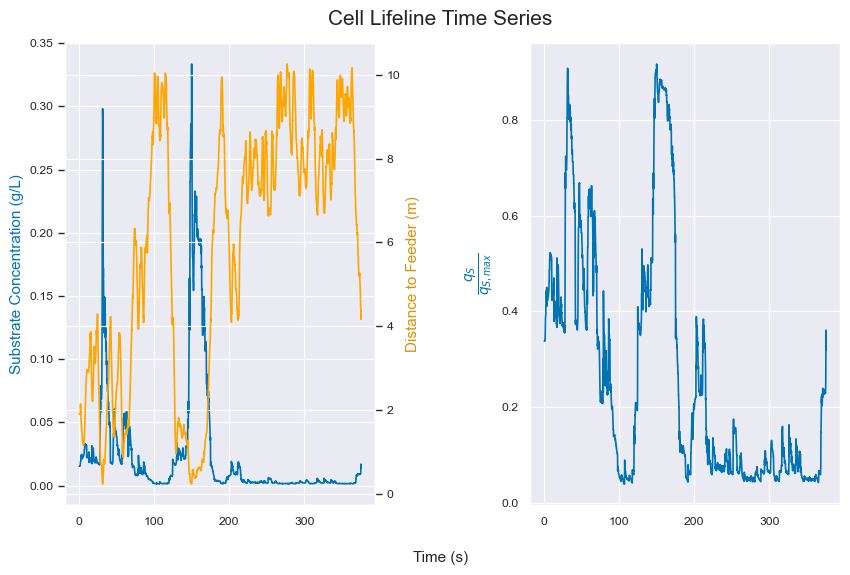

In [2]:
# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=time_array, y=C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11,
              color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=time_array, y=dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
              color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point
q_S= q_S_max*C_S_array/(K_S+C_S_array)
qS_qSmax = q_S/q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

#plt.title("Cell Lifeline Time Series", fontsize=14)
sns.lineplot(x=time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14,
                color=sns.color_palette()[0])
#ax2 = ax[1].twinx()
#sns.lineplot(x=time, y=dist_feed_point, color='orange', ax=ax2)
#ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
#              color=sns.color_palette()[1])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


### 1.2) dFBA


In [11]:
import cobra
from cobra.io import load_model
import numpy as np

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

def lexicographic_dFBA(C_S: float, model=load_model("textbook")):
    # Re-build model
    model = load_model("textbook")
    
    # Change solver --> When we have cplex cplex, by now glpk
    model.solver = 'glpk'
    
    # Add glucose import as a constraint wih monod
    glucose_max_import = - q_S_max * C_S / (K_S + C_S)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    
    # 1) Optimize aux-LP to get only feasible solutions
    cobra.util.solver.add_lp_feasibility(model)
    error = model.slim_optimize()
    # Establish feasibility objective as constraint
    cobra.util.fix_objective_as_constraint(model)
    
    # 2) Optimize the Biomass --> Import glucose in Lexicographic form and optimize for qS
    lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                    ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'min'])
    
    # 3) Solve model and compute fluxes
    solution = model.optimize()
    fluxes = np.array(model.optimize().fluxes.tolist())
    
    return model, solution, error
    

Solve dFBA with C_S from the lifelines

In [7]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=time_array,)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0,len(time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as csv file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)


100%|██████████| 3756/3756 [29:36<00:00,  2.11it/s]


# Training on Multiple Lifeline 


In [10]:
import os
import pandas as pd
import numpy as np

folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376 # reduced timepoints by 10 for faster runs, just temporary 

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 376 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_18092\3474851630.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_18092\3474851630.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_18092\3474851630.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expecte

Shape mismatch for file: lifeline_0_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_106_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_120_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_197_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_263_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_397_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_424_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_581_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_658_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_669_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismatch for file: lifeline_801_dFBA_pd_df.csv. Expected (376, 48) but got (38, 48)
Shape mismat

In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming data_3d is original data with shape (n_timesteps, n_samples, n_features)
# Example: n_timesteps = 376, n_samples = 14, n_features = 48

n_timesteps, n_samples, n_features = data_3d.shape

# Initialize a StandardScaler for each feature for each sample
scalers = [[StandardScaler() for _ in range(n_features)] for _ in range(n_samples)]

# Normalized data will have the same shape as data_3d initially
normalized_data = np.empty_like(data_3d, dtype=float)

# Apply the scalers to each feature for each sample across all timesteps
for sample_index in range(n_samples):
    for feature_index in range(n_features):
        # Extract the feature data for the current sample
        feature_data = data_3d[:, sample_index, feature_index].reshape(-1, 1)
        
        # Fit and transform the data using the corresponding scaler
        normalized_feature_data = scalers[sample_index][feature_index].fit_transform(feature_data)
        
        # Assign the normalized data back to its position in the normalized_data array
        normalized_data[:, sample_index, feature_index] = normalized_feature_data.flatten()

# Transpose normalized_data to have the shape (n_samples, n_timesteps, n_features)
normalized_data = np.transpose(normalized_data, (1, 0, 2))

In [37]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Assuming five_lifeline is a 3D array with the shape (1, 376, 48)
train_data = normalized_data
val_data = train_data  # Using the same data for validation as a placeholder

# Define the input layer with the shape (timesteps, features)
input_shape = (train_data.shape[1], train_data.shape[2])
inputs = Input(shape=input_shape)

# Encoder layers with glorot_uniform initializer
encoded = LSTM(300, activation='tanh', return_sequences=True,
               kernel_initializer=glorot_uniform(seed=0))(inputs)
encoded = LSTM(200, activation='tanh', return_sequences=True,
               kernel_initializer=glorot_uniform(seed=0))(encoded)
encoded = LSTM(150, activation='tanh', return_sequences=False,
               kernel_initializer=glorot_uniform(seed=0))(encoded)
# Latent space with he_normal initializer
latent_space = Dense(100, activation='tanh',
                     kernel_initializer=he_normal(seed=0))(encoded)

# Decoder layers, repeat the latent space at each timestep
decoded = RepeatVector(input_shape[0])(latent_space)
decoded = LSTM(150, activation='tanh', return_sequences=True,
               kernel_initializer=glorot_uniform(seed=0))(decoded)
decoded = LSTM(200, activation='tanh', return_sequences=True,
               kernel_initializer=glorot_uniform(seed=0))(decoded)
decoded = LSTM(300, activation='tanh', return_sequences=True,
               kernel_initializer=glorot_uniform(seed=0))(decoded)

# Output layer, reconstruct the original input
outputs = TimeDistributed(Dense(input_shape[1]))(decoded)

# Create the autoencoder model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 38, 48)]          0         
                                                                 
 lstm_107 (LSTM)             (None, 38, 300)           418800    
                                                                 
 lstm_108 (LSTM)             (None, 38, 200)           400800    
                                                                 
 lstm_109 (LSTM)             (None, 150)               210600    
                                                                 
 dense_48 (Dense)            (None, 100)               15100     
                                                                 
 repeat_vector_24 (RepeatVe  (None, 38, 100)           0         
 ctor)                                                           
                                                          

In [38]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model
history = autoencoder.fit(
    train_data,
    train_data,
    epochs = 800,
    batch_size=32,  # Adjust the batch size if necessary
    validation_data=(val_data, val_data),
    callbacks=[reduce_lr, early_stop]
)

# Predict on the validation set
val_predictions = autoencoder.predict(val_data)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")


Epoch 1/800
1/1 [==============================] - 12s 12s/step - loss: 0.9926 - val_loss: 0.9898 - lr: 0.0010
Epoch 2/800
1/1 [==============================] - 0s 353ms/step - loss: 0.9898 - val_loss: 0.9848 - lr: 0.0010
Epoch 3/800
1/1 [==============================] - 0s 326ms/step - loss: 0.9848 - val_loss: 0.9790 - lr: 0.0010
Epoch 4/800
1/1 [==============================] - 0s 299ms/step - loss: 0.9790 - val_loss: 0.9672 - lr: 0.0010
Epoch 5/800
1/1 [==============================] - 0s 353ms/step - loss: 0.9672 - val_loss: 0.9491 - lr: 0.0010
Epoch 6/800
1/1 [==============================] - 0s 296ms/step - loss: 0.9491 - val_loss: 0.9406 - lr: 0.0010
Epoch 7/800
1/1 [==============================] - 0s 398ms/step - loss: 0.9406 - val_loss: 1.0042 - lr: 0.0010
Epoch 8/800
1/1 [==============================] - 0s 301ms/step - loss: 1.0042 - val_loss: 0.9481 - lr: 0.0010
Epoch 9/800
1/1 [==============================] - 0s 301ms/step - loss: 0.9481 - val_loss: 0.9686 - lr: 

1/1 [==============================] - 0s 125ms/step


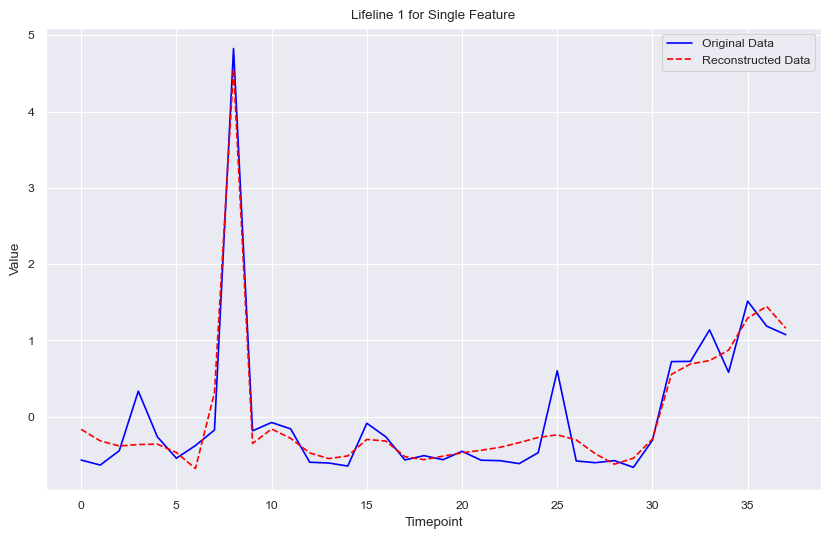

In [41]:
import matplotlib.pyplot as plt

# Assuming that one_lifeline is your data reshaped correctly for the model input
# Example: one_lifeline = np.random.rand(1, 376, 1)  # Use your actual reshaped data here

# Predict the reconstruction for the lifeline
reconstructed = autoencoder.predict(train_data)
lifeline = 4
feature = 6 

# Flatten the arrays to be able to plot them since they contain a single feature
scaled_series = train_data[lifeline,:,feature]
reconstructed_series = reconstructed[lifeline,:,feature]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title('Lifeline 1 for Single Feature')
plt.xlabel('Timepoint')
plt.ylabel('Value')
plt.legend()
plt.show()


In [25]:
import optuna
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import glorot_uniform, he_normal
from sklearn.model_selection import train_test_split

# Assuming 'normalized_data' is defined elsewhere in your script
# normalized_data = ...

# Define the objective function to optimize
def objective(trial):
    # Hyperparameter setting
    lstm_units = trial.suggest_categorical('lstm_units', [200, 300, 350, 400])
    lstm_units_layer2 = trial.suggest_categorical('lstm_units_layer2', [200, 250, 275, 300])  # Key name changed
    dense_units = trial.suggest_categorical('dense_units', [50, 100, 150, 200])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Split the data
    train_data, val_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

    # Define the input layer with the shape (timesteps, features)
    input_shape = (train_data.shape[1], train_data.shape[2])
    inputs = Input(shape=input_shape)

    # Encoder layers with glorot_uniform initializer
    encoded = LSTM(lstm_units, activation='tanh', return_sequences=True,
                   kernel_initializer=glorot_uniform(seed=0))(inputs)
    encoded = LSTM(lstm_units_layer2, activation='tanh', return_sequences=False,
                   kernel_initializer=glorot_uniform(seed=0))(encoded)

    # Latent space with he_normal initializer
    latent_space = Dense(dense_units, activation='tanh',
                         kernel_initializer=he_normal(seed=0))(encoded)

    # Decoder layers, repeat the latent space at each timestep
    decoded = RepeatVector(input_shape[0])(latent_space)
    decoded = LSTM(lstm_units_layer2, activation='tanh', return_sequences=True,
                   kernel_initializer=glorot_uniform(seed=0))(decoded)
    decoded = LSTM(lstm_units, activation='tanh', return_sequences=True,
                   kernel_initializer=glorot_uniform(seed=0))(decoded)

    # Output layer, reconstruct the original input
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)

    # Create the autoencoder model
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Early stopping and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

    # Model training
    history = autoencoder.fit(train_data, train_data, epochs=700, batch_size=batch_size,
                              validation_data=(val_data, val_data), callbacks=[early_stop, reduce_lr], verbose=0)

    # Retrieve the best score
    best_score = min(history.history['val_loss'])
    return best_score

# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(objective, n_trials=10)  # You can change n_trials to the number of iterations you want to perform

# Print the result
print(study.best_params)


[I 2024-02-21 13:53:44,135] A new study created in memory with name: no-name-9527dc86-4666-4c77-bade-617d26e31c4c
C:\Users\elysi\AppData\Local\Temp\ipykernel_18092\577897805.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-02-21 13:53:58,746] Trial 0 finished with value: 0.9940025210380554 and parameters: {'lstm_units': 200, 'lstm_units_layer2': 275, 'dense_units': 200, 'learning_rate': 4.57064882981988e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9940025210380554.
[I 2024-02-21 13:54:25,044] Trial 1 finished with value: 0.807985782623291 and parameters: {'lstm_units': 400, 'lstm_units_layer2': 250, 'dense_units': 100, 'learning_rate': 0.00021939476012720676, 'batch_size': 64}. Best is trial 1 with value: 0.807985782623291.
[I 2024-02-21 

{'lstm_units': 400, 'lstm_units_layer2': 300, 'dense_units': 100, 'learning_rate': 0.00040225479094866155, 'batch_size': 16}


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Optimized hyperparameters
lstm_units = study.best_params['lstm_units'] # Optimized LSTM units for both encoder and decoder
lstm_units_layer2 = study.best_params['lstm_units_layer2']
dense_units = study.best_params['dense_units'] # Optimized Dense units for latent representation
learning_rate = study.best_params['learning_rate']  # Optimized learning rate
batch_size = study.best_params['batch_size']  # Optimized batch size

# Split the data
train_data, val_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

# Define the input layer with the shape (timesteps, features)
input_shape = (train_data.shape[1], train_data.shape[2])
inputs = Input(shape=input_shape)

# Encoder layers with glorot_uniform initializer
encoded = LSTM(lstm_units, activation='tanh', return_sequences=True,
                   kernel_initializer=glorot_uniform(seed=0))(inputs)
encoded = LSTM(lstm_units_layer2, activation='tanh', return_sequences=False,
                   kernel_initializer=glorot_uniform(seed=0))(encoded)

# Latent space with he_normal initializer
latent_space = Dense(dense_units, activation='tanh',
                         kernel_initializer=he_normal(seed=0))(encoded)

# Decoder layers, repeat the latent space at each timestep
decoded = RepeatVector(input_shape[0])(latent_space)
decoded = LSTM(lstm_units_layer2, activation='tanh', return_sequences=True,
                   kernel_initializer=glorot_uniform(seed=0))(decoded)
decoded = LSTM(lstm_units, activation='tanh', return_sequences=True,
                   kernel_initializer=glorot_uniform(seed=0))(decoded)

# Output layer, reconstruct the original input
outputs = TimeDistributed(Dense(input_shape[1]))(decoded)

# Create the autoencoder model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = autoencoder.fit(train_data, train_data, epochs=400, batch_size=batch_size,
                              validation_data=(val_data, val_data), callbacks=[early_stop, reduce_lr], verbose=0)
# Predict on the validation set
val_predictions = autoencoder.predict(val_data)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")


1/1 [==============================] - 1s 1s/step
Validation RMSE: 0.9130694072270705


1/1 [==============================] - 0s 125ms/step


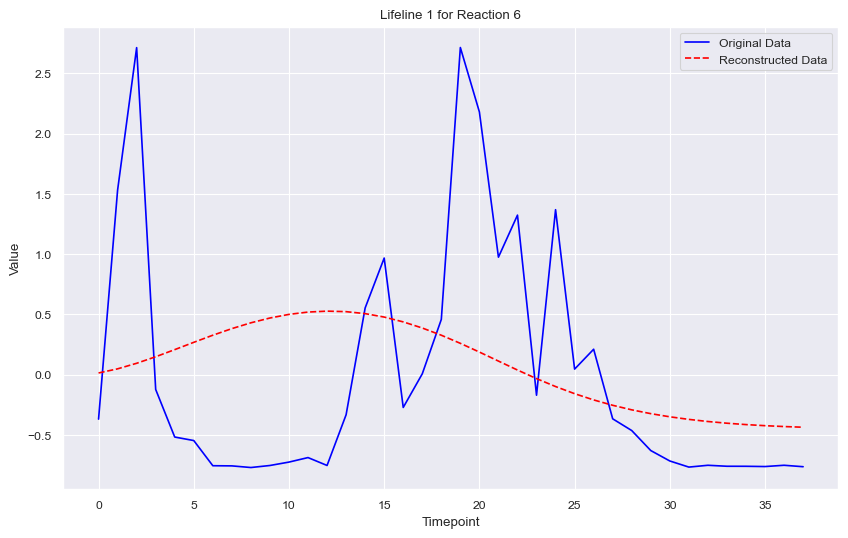

In [30]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 12  # Index for lifeline 0 
reaction_index = 6 # Reaction index, biomass reaction

# Predict the reconstruction for the lifeline
reconstructed = autoencoder.predict(normalized_data)

# Extract series for plotting
scaled_series = normalized_data[lifeline_index, :, reaction_index]
reconstructed_series = reconstructed[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline 1 for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Model

# Assuming 'encoded' is the output of your last encoder layer and 'inputs' is your input layer
latent_model = Model(inputs, latent_space)
latent_representations = latent_model.predict(train_data)


In [ ]:
import pandas as pd

# Convert the latent representations to a DataFrame
latent_df = pd.DataFrame(latent_representations)

# Specify your desired Excel file path
excel_file_path = '/mnt/data/latent_representations.xlsx'

# Save the DataFrame to an Excel file
latent_df.to_excel(excel_file_path, index=False)

print(f"Latent representations saved to {excel_file_path}")
